In [2]:
# --- HACKATHON ML PIPELINE: SETUP ---
import sys
import numpy as np
import matplotlib.pyplot as plt

# The Modern Microscopy Stack
import sidpy
import SciFiReaders
import atomai
from sklearn.decomposition import TruncatedSVD

# Verify versions
print(f"Environment Ready.")
print(f"AtomAI Version: {atomai.__version__} (For Deep Learning)")
print(f"Sidpy Version: {sidpy.__version__} (For Data Handling)")

You don't have igor2 installed.     If you wish to open igor files, you will need to install it     (pip install igor2) before attempting.
You don't have gwyfile installed.     If you wish to open .gwy files, you will need to      install it (pip install gwyfile) before attempting.
Environment Ready.
AtomAI Version: 0.8.1 (For Deep Learning)
Sidpy Version: 0.12.8 (For Data Handling)


In [23]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
from sklearn.metrics import confusion_matrix
import seaborn as sns

Loading data via DM3Reader...
Keys found in file: ['Channel_000']
Found Dataset 'Channel_000' with shape (1024, 1024, 10)
 -> Selected 'Channel_000' as the 3D Image Stack
Transposing data to (Time, Height, Width)...
Processing Stack Shape: 10 Frames, 1024x1024 Pixels
Running SVD Denoising...


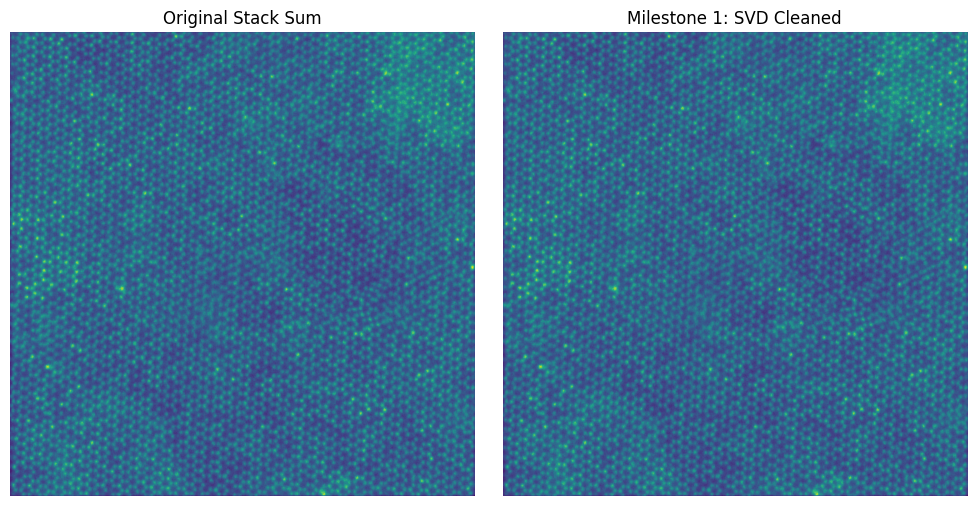

✅ Milestone 1 Complete. 'nIm' is now your Clean Input.


In [16]:
# --- MILESTONE 1: NATIVE DATA INGEST & SVD CLEANING (CORRECTED) ---

import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD

# The Modern Microscopy Stack
import sidpy
from SciFiReaders import DM3Reader

# 1. Define File Path
file_path = '/home/gaafoor12/Downloads/globusconnectpersonal-latest/QuaternaryAlloyMoWSSe/3D Stack align2.dm3'

# 2. Load using SciFiReaders
print(f"Loading data via DM3Reader...")
dm3_reader = DM3Reader(file_path)
datasets = dm3_reader.read()

# DEBUG: See what is inside
print(f"Keys found in file: {list(datasets.keys())}")

# 3. Find the correct 3D Stack
# Since 'datasets' is a dictionary, we must loop through .items()
sid_dataset = None

for key, ds in datasets.items():
    # We ensure the item is actually a Dataset (not just a metadata string)
    if isinstance(ds, sidpy.Dataset):
        print(f"Found Dataset '{key}' with shape {ds.shape}")
        if ds.ndim == 3:
            sid_dataset = ds
            print(f" -> Selected '{key}' as the 3D Image Stack")
            break

if sid_dataset is None:
    # Fallback: Just grab the first dataset object found
    print("Warning: No specific 3D stack found. Using the first available dataset.")
    for ds in datasets.values():
        if isinstance(ds, sidpy.Dataset):
            sid_dataset = ds
            break

# 4. Extract & Orient Data
raw_stack = np.array(sid_dataset)

# SVD requires (Time, Height, Width). Fix orientation if needed.
if raw_stack.shape[0] > raw_stack.shape[2]:
    print("Transposing data to (Time, Height, Width)...")
    raw_stack = np.moveaxis(raw_stack, -1, 0)

t, h, w = raw_stack.shape
print(f"Processing Stack Shape: {t} Frames, {h}x{w} Pixels")

# 5. SVD Denoising
# Flatten: (Time, Y, X) -> (Time, Pixels)
X_flat = raw_stack.reshape(t, h * w) 

# Run SVD: Keep top 4 components (Atoms), discard rest (Noise)
print("Running SVD Denoising...")
svd = TruncatedSVD(n_components=4, random_state=42)
X_reduced = svd.fit_transform(X_flat)
X_reconstructed_flat = svd.inverse_transform(X_reduced)

# Reconstruct
clean_stack = X_reconstructed_flat.reshape(t, h, w)
nIm_SVD = np.sum(clean_stack, axis=0)

# Normalize
nIm = (nIm_SVD - np.min(nIm_SVD)) / np.ptp(nIm_SVD)

# 6. Visualization
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.title("Original Stack Sum")
plt.imshow(np.sum(raw_stack, axis=0), cmap='viridis')
plt.axis('off')

plt.subplot(1,2,2)
plt.title("Milestone 1: SVD Cleaned")
plt.imshow(nIm, cmap='viridis')
plt.axis('off')
plt.tight_layout()
plt.show()

print("✅ Milestone 1 Complete. 'nIm' is now your Clean Input.")

Detecting atomic peaks...
Found 6400 atoms.
Classifying A/B sites using geometric neighbors...
Classification Result: 3715 A-Sites, 2685 B-Sites


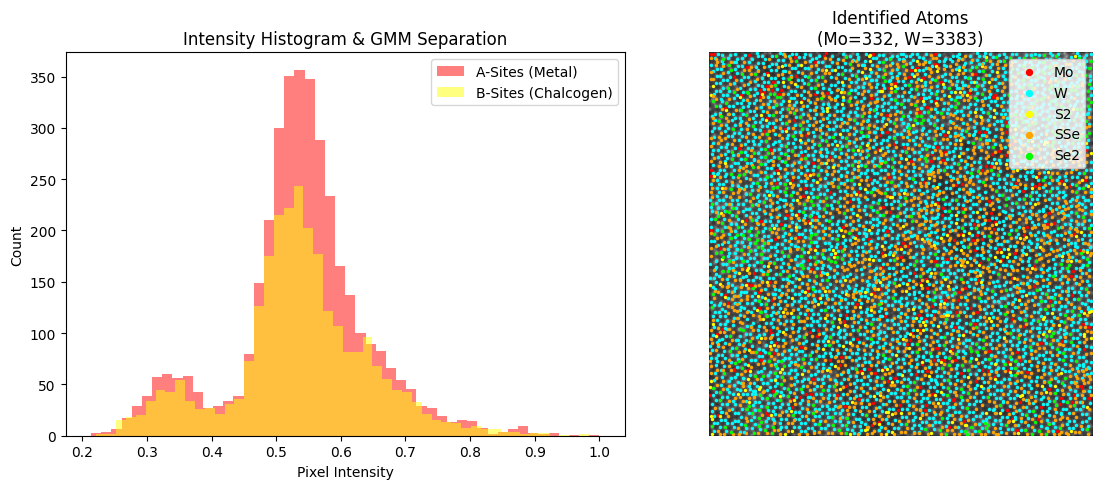

Milestone 2 Complete. Ground Truth Labels Generated.


In [17]:
# --- MILESTONE 2: AUTOMATED GROUND TRUTH GENERATION ---

from skimage.feature import peak_local_max
from sklearn.neighbors import NearestNeighbors
from sklearn.mixture import GaussianMixture
import matplotlib.patches as mpatches

# 1. Detect Atoms
# We find local maxima in the clean SVD image.
# min_distance ensures we don't pick up the same atom twice.
print("Detecting atomic peaks...")
coordinates = peak_local_max(nIm, min_distance=3, threshold_rel=0.1, exclude_border=True)

# Reverse coordinates to match (x, y) plotting conventions if needed, 
# but for matrix indexing we keep (row, col).
print(f"Found {len(coordinates)} atoms.")

# 2. Separate A-Sites (Metal) from B-Sites (Chalcogen)
# We use a KDTree to find neighbors instantly, replacing the slow manual loops.
print("Classifying A/B sites using geometric neighbors...")
nbrs = NearestNeighbors(n_neighbors=4, algorithm='kd_tree').fit(coordinates)
distances, indices = nbrs.kneighbors(coordinates)

a_sites = []
b_sites = []

# Loop through each atom to check its geometric environment
# Logic: Look at 3 nearest neighbors. Check if they are mostly above or below.
for i in range(len(coordinates)):
    # Get indices of neighbors (excluding self, which is index 0)
    neighbor_indices = indices[i, 1:] 
    
    # Calculate vertical distance (row difference)
    # Postive dy means neighbor is 'below' (higher row index)
    y_diffs = [coordinates[n][0] - coordinates[i][0] for n in neighbor_indices]
    
    # Count how many neighbors are "below" vs "above"
    # This geometric signature separates the two sublattices in TMD crystals
    below = sum(dy > 0 for dy in y_diffs)
    above = sum(dy < 0 for dy in y_diffs)
    
    # A-Site (Metal): Typically has 2 neighbors above, 1 below (in this projection)
    # B-Site (Chalcogen): Typically has 1 neighbor above, 2 below
    if above > below:
        b_sites.append(i)
    else:
        a_sites.append(i)

print(f"Classification Result: {len(a_sites)} A-Sites, {len(b_sites)} B-Sites")

# 3. Extract Intensities for GMM Clustering
# We grab the pixel intensity value at each identified coordinate
intensities = nIm[coordinates[:, 0], coordinates[:, 1]]
a_intensities = intensities[a_sites].reshape(-1, 1)
b_intensities = intensities[b_sites].reshape(-1, 1)

# 4. GMM Clustering (The "Smart" Thresholding)
# A-Sites have 2 classes: Mo (Darker) and W (Brighter)
gmm_a = GaussianMixture(n_components=2, random_state=42)
gmm_a.fit(a_intensities)
a_labels = gmm_a.predict(a_intensities)

# Sort labels by mean intensity so 0 is always Mo and 1 is always W
sorted_idx_a = np.argsort(gmm_a.means_.flatten())
label_map_a = {old_idx: new_idx for new_idx, old_idx in enumerate(sorted_idx_a)}
a_labels = np.array([label_map_a[l] for l in a_labels])
# Map to final classes: 0=Mo, 1=W

# B-Sites have 3 classes: S2 (Dark), SSe (Mid), Se2 (Bright)
gmm_b = GaussianMixture(n_components=3, random_state=42)
gmm_b.fit(b_intensities)
b_labels = gmm_b.predict(b_intensities)

# Sort labels by mean intensity
sorted_idx_b = np.argsort(gmm_b.means_.flatten())
label_map_b = {old_idx: new_idx for new_idx, old_idx in enumerate(sorted_idx_b)}
b_labels = np.array([label_map_b[l] for l in b_labels])
# Map to final classes: 2=S2, 3=SSe, 4=Se2 (Offset by 2 to keep unique)
b_labels += 2 

# 5. Visualize the Ground Truth
plt.figure(figsize=(12, 5))

# Plot Histogram with GMM boundaries
plt.subplot(1, 2, 1)
plt.hist(a_intensities, bins=50, color='red', alpha=0.5, label='A-Sites (Metal)')
plt.hist(b_intensities, bins=50, color='yellow', alpha=0.5, label='B-Sites (Chalcogen)')
plt.title("Intensity Histogram & GMM Separation")
plt.xlabel("Pixel Intensity")
plt.ylabel("Count")
plt.legend()

# Plot Spatial Map
plt.subplot(1, 2, 2)
plt.imshow(nIm, cmap='gray')
plt.title(f"Identified Atoms\n(Mo={len(a_labels[a_labels==0])}, W={len(a_labels[a_labels==1])})")
# Plot A-Sites (Red=Mo, Blue=W)
plt.scatter(coordinates[a_sites][a_labels==0, 1], coordinates[a_sites][a_labels==0, 0], c='red', s=2, label='Mo')
plt.scatter(coordinates[a_sites][a_labels==1, 1], coordinates[a_sites][a_labels==1, 0], c='cyan', s=2, label='W')
# Plot B-Sites (Yellow=S2, Orange=SSe, Green=Se2)
plt.scatter(coordinates[b_sites][b_labels==2, 1], coordinates[b_sites][b_labels==2, 0], c='yellow', s=2, label='S2')
plt.scatter(coordinates[b_sites][b_labels==3, 1], coordinates[b_sites][b_labels==3, 0], c='orange', s=2, label='SSe')
plt.scatter(coordinates[b_sites][b_labels==4, 1], coordinates[b_sites][b_labels==4, 0], c='lime', s=2, label='Se2')
plt.legend(loc='upper right', markerscale=3)
plt.axis('off')

plt.tight_layout()
plt.show()

print("Milestone 2 Complete. Ground Truth Labels Generated.")

Total labeled atoms: 6400 / 6400
Extracting 32x32 patches...
Dataset Created:
 -> X Shape: torch.Size([6400, 1, 32, 32]) (N, C, H, W)
 -> y Shape: torch.Size([6400])


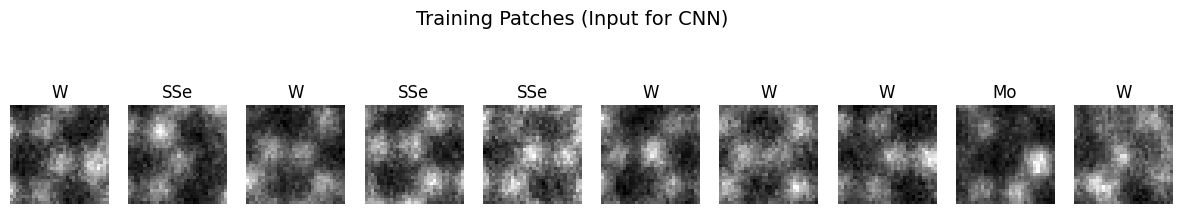

✅ Milestone 3 Complete. Data is ready for PyTorch.


In [18]:
# --- MILESTONE 3: PATCH EXTRACTION & DATASET CREATION ---

import torch
import numpy as np

# 1. Consolidate Labels
# We need to map the separate A/B labels back to the master coordinate list
# Initialize with -1 (for debugging, though all should be filled)
all_labels = np.full(len(coordinates), -1)

# Assign A-Site labels (0=Mo, 1=W)
all_labels[a_sites] = a_labels

# Assign B-Site labels (2=S2, 3=SSe, 4=Se2)
all_labels[b_sites] = b_labels

# Verify we didn't miss anyone
print(f"Total labeled atoms: {np.sum(all_labels != -1)} / {len(coordinates)}")

# 2. Define Patch Extraction Logic
def extract_patches(image, coords, window_size=32):
    """
    Extracts a square patch around each coordinate.
    Handles boundaries by padding the image with zeros if the atom is too close to the edge.
    """
    half_w = window_size // 2
    img_h, img_w = image.shape
    
    # Pad image to handle edge atoms safely
    padded_img = np.pad(image, ((half_w, half_w), (half_w, half_w)), mode='constant')
    
    patches = []
    valid_indices = [] # Keep track of which atoms we successfully extracted
    
    for i, (r, c) in enumerate(coords):
        # Adjust coordinates for padding
        r_pad, c_pad = r + half_w, c + half_w
        
        # Slice
        patch = padded_img[r_pad-half_w : r_pad+half_w, c_pad-half_w : c_pad+half_w]
        
        # simple check to ensure patch is correct size
        if patch.shape == (window_size, window_size):
            patches.append(patch)
            valid_indices.append(i)
            
    return np.array(patches), np.array(valid_indices)

# 3. Execute Extraction
PATCH_SIZE = 32
print(f"Extracting {PATCH_SIZE}x{PATCH_SIZE} patches...")
X_raw, valid_idx = extract_patches(nIm, coordinates, window_size=PATCH_SIZE)
y_raw = all_labels[valid_idx]

# 4. Convert to PyTorch Tensors
# PyTorch expects (N, Channels, Height, Width)
# We add a dimension for Channels (1) since it's grayscale
X_tensor = torch.tensor(X_raw, dtype=torch.float32).unsqueeze(1) 
y_tensor = torch.tensor(y_raw, dtype=torch.long)

print(f"Dataset Created:")
print(f" -> X Shape: {X_tensor.shape} (N, C, H, W)")
print(f" -> y Shape: {y_tensor.shape}")

# 5. Visualize a few patches to verify
class_names = {0: 'Mo', 1: 'W', 2: 'S2', 3: 'SSe', 4: 'Se2'}

plt.figure(figsize=(15, 3))
for i in range(10):
    idx = np.random.randint(0, len(X_tensor))
    plt.subplot(1, 10, i+1)
    plt.imshow(X_tensor[idx, 0].numpy(), cmap='gray')
    label_id = y_tensor[idx].item()
    plt.title(class_names[label_id])
    plt.axis('off')
plt.suptitle("Training Patches (Input for CNN)", fontsize=14)
plt.show()

print("✅ Milestone 3 Complete. Data is ready for PyTorch.")

Total Dataset Size: 6400 patches
------------------------------
Class 0 (Mo (Metal)): 332 samples (5.2%)
Class 1 (W (Metal)): 3383 samples (52.9%)
Class 2 (S2 (Chalcogen)): 335 samples (5.2%)
Class 3 (SSe (Chalcogen)): 1747 samples (27.3%)
Class 4 (Se2 (Chalcogen)): 603 samples (9.4%)


/tmp/ipykernel_239351/2845513645.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[label_map[i] for i in unique], y=counts, palette='viridis')


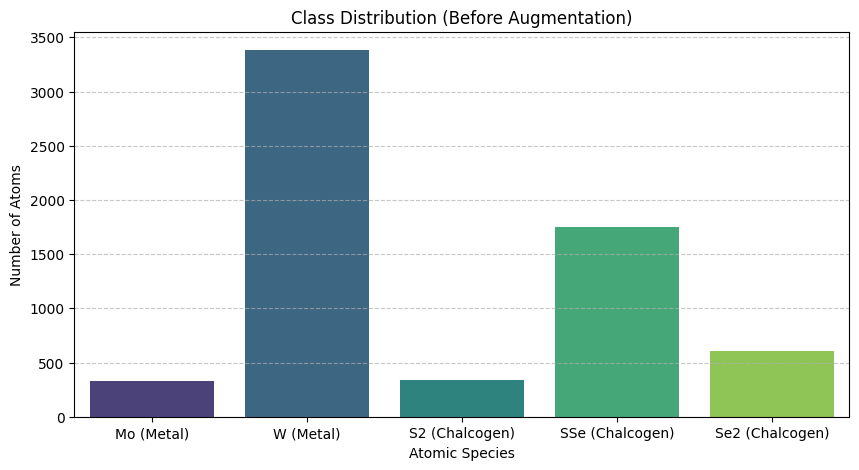

------------------------------
Imbalance Ratio: 1 : 10.2
⚠️ CRITICAL IMBALANCE DETECTED.
Recommendation: Apply Data Augmentation (Rotation/Flipping) to minority classes.


In [19]:
# --- MILESTONE 2.5: EXPLORATORY DATA ANALYSIS (EDA) ---

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Decode Labels for Readability
# Map integer labels back to chemical names
label_map = {0: 'Mo (Metal)', 1: 'W (Metal)', 2: 'S2 (Chalcogen)', 3: 'SSe (Chalcogen)', 4: 'Se2 (Chalcogen)'}
labels_decoded = [label_map[l.item()] for l in y_tensor]

# 2. Calculate Class Distribution
unique, counts = np.unique(y_tensor.numpy(), return_counts=True)
total_samples = len(y_tensor)

print(f"Total Dataset Size: {total_samples} patches")
print("-" * 30)
for label, count in zip(unique, counts):
    pct = (count / total_samples) * 100
    print(f"Class {label} ({label_map[label]}): {count} samples ({pct:.1f}%)")

# 3. Visualize Imbalance
plt.figure(figsize=(10, 5))
sns.barplot(x=[label_map[i] for i in unique], y=counts, palette='viridis')
plt.title("Class Distribution (Before Augmentation)")
plt.ylabel("Number of Atoms")
plt.xlabel("Atomic Species")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 4. Analyze Imbalance Severity
min_class = np.min(counts)
max_class = np.max(counts)
imbalance_ratio = max_class / min_class

print(f"-" * 30)
print(f"Imbalance Ratio: 1 : {imbalance_ratio:.1f}")

if imbalance_ratio > 2.0:
    print("⚠️ CRITICAL IMBALANCE DETECTED.")
    print("Recommendation: Apply Data Augmentation (Rotation/Flipping) to minority classes.")
else:
    print("✅ Class balance is acceptable.")

Target Samples per Class: ~3383
Augmenting Class 0 (Mo (Metal))...
 -> Performing Deep Augmentation for Mo (Metal)
Augmenting Class 2 (S2 (Chalcogen))...
 -> Performing Deep Augmentation for S2 (Chalcogen)
Augmenting Class 3 (SSe (Chalcogen))...
Augmenting Class 4 (Se2 (Chalcogen))...
 -> Performing Deep Augmentation for Se2 (Chalcogen)


/tmp/ipykernel_239351/4021249315.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[label_map[i] for i in unique_new], y=counts_new, palette='viridis')


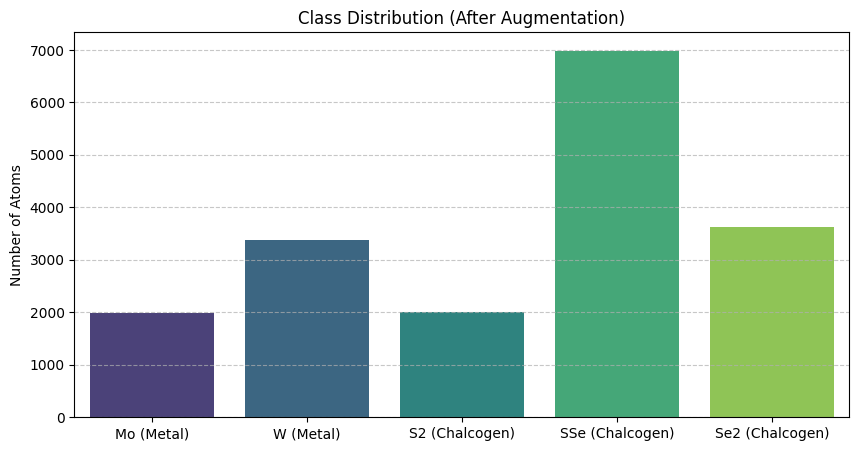

Original Size: 6400 -> Augmented Size: 17991
Milestone 2.6 Complete. Dataset Balanced.


In [20]:
# --- MILESTONE 2.6: STRATEGIC DATA AUGMENTATION ---

import torch

def augment_minority_classes(X, y, target_count):
    """
    Augments minority classes using rotation and flipping until they reach target_count.
    """
    X_aug = [X]
    y_aug = [y]
    
    unique_classes, class_counts = np.unique(y.numpy(), return_counts=True)
    
    for cls in unique_classes:
        count = class_counts[cls]
        
        # If class is under-represented (less than 80% of the majority class)
        if count < target_count * 0.8:
            print(f"Augmenting Class {cls} ({label_map[cls]})...")
            
            # Extract only this class
            indices = (y == cls).nonzero(as_tuple=True)[0]
            X_curr = X[indices]
            
            # 1. Rotate 90 degrees
            X_rot90 = torch.rot90(X_curr, 1, [2, 3])
            X_aug.append(X_rot90)
            y_aug.append(torch.full((len(X_curr),), cls, dtype=torch.long))
            
            # 2. Rotate 180 degrees
            X_rot180 = torch.rot90(X_curr, 2, [2, 3])
            X_aug.append(X_rot180)
            y_aug.append(torch.full((len(X_curr),), cls, dtype=torch.long))
            
            # 3. Horizontal Flip
            X_flip = torch.flip(X_curr, [3])
            X_aug.append(X_flip)
            y_aug.append(torch.full((len(X_curr),), cls, dtype=torch.long))
            
            # If still not enough (like for Mo which is 10x smaller), Rotate 270 & Flip+Rotate
            if count * 4 < target_count:
                 print(f" -> Performing Deep Augmentation for {label_map[cls]}")
                 X_rot270 = torch.rot90(X_curr, 3, [2, 3])
                 X_aug.append(X_rot270)
                 y_aug.append(torch.full((len(X_curr),), cls, dtype=torch.long))
                 
                 # Vertical Flip (equivalent to Rotate 180 + Horizontal Flip)
                 X_vflip = torch.flip(X_curr, [2])
                 X_aug.append(X_vflip)
                 y_aug.append(torch.full((len(X_curr),), cls, dtype=torch.long))

    # Combine all data
    X_final = torch.cat(X_aug, dim=0)
    y_final = torch.cat(y_aug, dim=0)
    
    return X_final, y_final

# 1. Set Target (Aim to match the count of the largest class, e.g., W)
majority_count = np.max(counts)
print(f"Target Samples per Class: ~{majority_count}")

# 2. Apply Augmentation
X_train_aug, y_train_aug = augment_minority_classes(X_tensor, y_tensor, majority_count)

# 3. Verify New Distribution
unique_new, counts_new = np.unique(y_train_aug.numpy(), return_counts=True)

plt.figure(figsize=(10, 5))
sns.barplot(x=[label_map[i] for i in unique_new], y=counts_new, palette='viridis')
plt.title("Class Distribution (After Augmentation)")
plt.ylabel("Number of Atoms")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print(f"Original Size: {len(X_tensor)} -> Augmented Size: {len(X_train_aug)}")

# Update the tensors for training
X_tensor = X_train_aug
y_tensor = y_train_aug

print("Milestone 2.6 Complete. Dataset Balanced.")

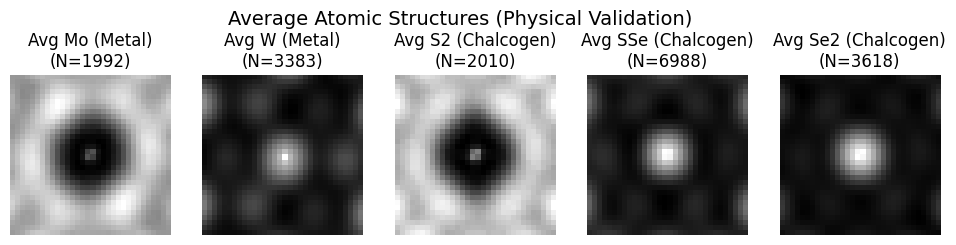

In [21]:
# --- MILESTONE 2.7: AVERAGE ATOM VISUALIZATION ---

plt.figure(figsize=(12, 3))
for i in range(5):
    # Get all patches for this class
    indices = (y_tensor == i).nonzero(as_tuple=True)[0]
    mean_img = torch.mean(X_tensor[indices].float(), dim=0).squeeze().numpy()
    
    plt.subplot(1, 5, i+1)
    plt.imshow(mean_img, cmap='gray')
    plt.title(f"Avg {label_map[i]}\n(N={len(indices)})")
    plt.axis('off')

plt.suptitle("Average Atomic Structures (Physical Validation)", fontsize=14)
plt.show()

In [28]:
# --- MILESTONE 4.0: MODEL ARCHITECTURE & DATA SETUP ---

# 1. Define the Neural Network Architecture
# A 3-layer CNN optimized for 32x32 atomic patches
class AtomNet(nn.Module):
    def __init__(self, num_classes=5):
        super(AtomNet, self).__init__()
        
        # Feature Extractor: Learns spatial hierarchies (edges -> shapes -> textures)
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32), 
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            # Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            # Block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        # Classifier: Maps extracted features to class probabilities
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 512),
            nn.ReLU(),
            nn.Dropout(0.4), # Dropout prevents overfitting
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# 2. Prepare Data Loaders
# Ensure X_tensor and y_tensor are populated from the Augmentation step
dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# Use a fixed seed for reproducible training/validation splits
train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, pin_memory=True)

print(f"Model and Data Loaders Ready.")
print(f"Training set: {len(train_dataset)} samples")
print(f"Validation set: {len(val_dataset)} samples")

Model and Data Loaders Ready.
Training set: 14392 samples
Validation set: 3599 samples


In [31]:
# --- MILESTONE 4.1 (v2): OPTIMIZED TRAINING WITH CLASS WEIGHTS ---

# 1. Calculate Class Weights
# We give higher weight to the classes the model is struggling with (Mo, S2)
# Standard (W, SSe, Se2) = 1.0
# Hard (Mo, S2) = 3.0 (Force the model to learn the geometry)
class_weights = torch.tensor([3.0, 1.0, 3.0, 1.0, 1.0]).to(device)

print(f"Applying Class Weights: {class_weights}")

# 2. Setup Training Configuration
model = AtomNet(num_classes=5).to(device) # Reset Model
criterion = nn.CrossEntropyLoss(weight=class_weights) # <--- Apply Weights Here
optimizer = optim.Adam(model.parameters(), lr=0.0005) # <--- Slower Learning Rate

# Scheduler: More aggressive reduction
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=5, factor=0.5)

# 3. Training Loop
num_epochs = 60
patience = 12        # Increased patience to allow for fine-tuning
counter = 0     
best_val_loss = float('inf') 
early_stop = False

print("\nStarting Optimized Training...")

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_acc = 100 * correct / total
    epoch_train_loss = running_loss / len(train_loader)
    
    # Validation Phase
    model.eval()
    val_correct = 0
    val_total = 0
    val_running_loss = 0.0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels) 
            
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            
    val_acc = 100 * val_correct / val_total
    epoch_val_loss = val_running_loss / len(val_loader)
    
    # Update Scheduler
    scheduler.step(val_acc)
    current_lr = optimizer.param_groups[0]['lr']
    
    # Early Stopping Logic
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        counter = 0 
        torch.save(model.state_dict(), "best_atom_net.pth")
        save_msg = "-> Model Saved (Loss Improved)"
    else:
        counter += 1
        save_msg = f"-> No Improvement ({counter}/{patience})"
        if counter >= patience:
            print(f"\nSTOPPING EARLY: Validation Loss hasn't improved for {patience} epochs.")
            early_stop = True

    print(f"Epoch [{epoch+1}/{num_epochs}] | LR: {current_lr:.6f} | Val Loss: {epoch_val_loss:.4f} | Val Acc: {val_acc:.2f}% {save_msg}")
    
    if early_stop:
        break
        
print(f"\nOptimization Complete. Best Validation Loss: {best_val_loss:.4f}")

Applying Class Weights: tensor([3., 1., 3., 1., 1.], device='cuda:0')

Starting Optimized Training...
Epoch [1/60] | LR: 0.000500 | Val Loss: 0.6519 | Val Acc: 70.74% -> Model Saved (Loss Improved)
Epoch [2/60] | LR: 0.000500 | Val Loss: 0.5989 | Val Acc: 72.69% -> Model Saved (Loss Improved)
Epoch [3/60] | LR: 0.000500 | Val Loss: 0.5510 | Val Acc: 76.41% -> Model Saved (Loss Improved)
Epoch [4/60] | LR: 0.000500 | Val Loss: 0.5649 | Val Acc: 75.22% -> No Improvement (1/12)
Epoch [5/60] | LR: 0.000500 | Val Loss: 0.5693 | Val Acc: 75.41% -> No Improvement (2/12)
Epoch [6/60] | LR: 0.000500 | Val Loss: 0.5418 | Val Acc: 76.52% -> Model Saved (Loss Improved)
Epoch [7/60] | LR: 0.000500 | Val Loss: 0.5311 | Val Acc: 76.80% -> Model Saved (Loss Improved)
Epoch [8/60] | LR: 0.000500 | Val Loss: 0.5191 | Val Acc: 78.16% -> Model Saved (Loss Improved)
Epoch [9/60] | LR: 0.000500 | Val Loss: 0.5104 | Val Acc: 77.72% -> Model Saved (Loss Improved)
Epoch [10/60] | LR: 0.000500 | Val Loss: 0.683

Loading best model weights...


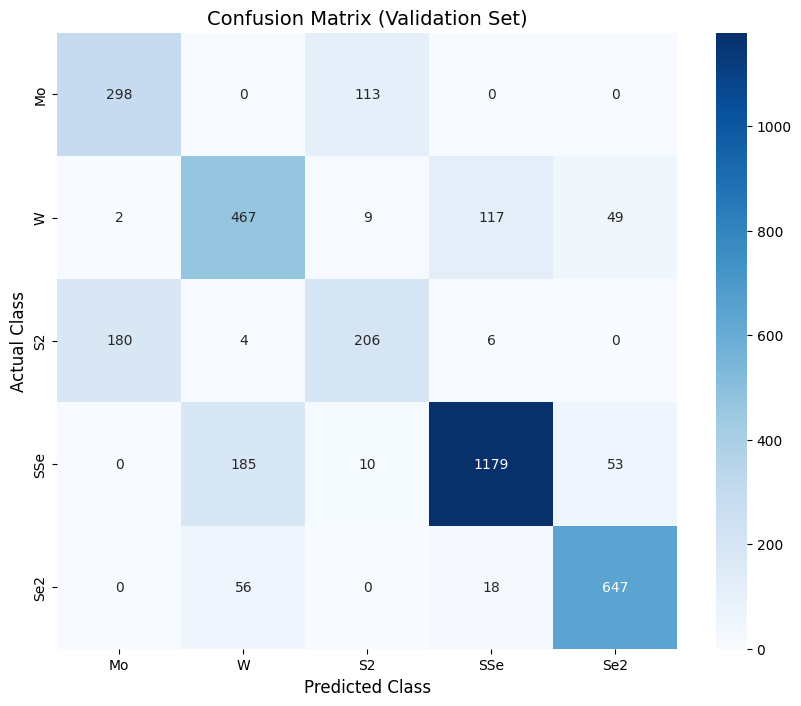

Final Validation Accuracy: 77.72%


In [32]:
# --- MILESTONE 4.2: EVALUATION & CONFUSION MATRIX ---

# 1. Load the Best Model
print("Loading best model weights...")
model.load_state_dict(torch.load("best_atom_net.pth"))
model.eval()

# 2. Generate Predictions
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# 3. Visualize Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Mo', 'W', 'S2', 'SSe', 'Se2'], 
            yticklabels=['Mo', 'W', 'S2', 'SSe', 'Se2'])
plt.xlabel('Predicted Class', fontsize=12)
plt.ylabel('Actual Class', fontsize=12)
plt.title('Confusion Matrix (Validation Set)', fontsize=14)
plt.show()

# 4. Calculate Final Accuracy
final_acc = 100 * np.sum(np.array(y_true) == np.array(y_pred)) / len(y_true)
print(f"Final Validation Accuracy: {final_acc:.2f}%")

In [33]:
# --- MILESTONE 3.5 & 4: CONTEXT EXPANSION (48x48) & RETRAINING ---

# 1. RE-EXTRACT PATCHES (Size 48x48)
print("1. Upgrading Data Context (32px -> 48px)...")
PATCH_SIZE = 48  # <--- The Key Fix

# We use the raw image (nIm) and coordinates from Milestone 2
# (Ensure 'nIm', 'coordinates', 'a_sites', 'b_sites' are still in memory)

# Re-consolidate labels
all_labels = np.full(len(coordinates), -1)
all_labels[a_sites] = a_labels
all_labels[b_sites] = b_labels

# Extraction Logic
half_w = PATCH_SIZE // 2
padded_img = np.pad(nIm, ((half_w, half_w), (half_w, half_w)), mode='constant')
patches = []
valid_indices = []

for i, (r, c) in enumerate(coordinates):
    r_pad, c_pad = r + half_w, c + half_w
    patch = padded_img[r_pad-half_w : r_pad+half_w, c_pad-half_w : c_pad+half_w]
    if patch.shape == (PATCH_SIZE, PATCH_SIZE):
        patches.append(patch)
        valid_indices.append(i)

X_raw = np.array(patches)
y_raw = all_labels[valid_indices]

# Convert to Tensor
X_tensor = torch.tensor(X_raw, dtype=torch.float32).unsqueeze(1)
y_tensor = torch.tensor(y_raw, dtype=torch.long)
print(f"   -> Extracted {len(X_tensor)} patches of size {PATCH_SIZE}x{PATCH_SIZE}")

# 2. RE-AUGMENT (Physics-Based)
print("2. Re-Applying Augmentation...")
def augment_data(X, y):
    X_aug, y_aug = [X], [y]
    unique, counts = np.unique(y.numpy(), return_counts=True)
    target = np.max(counts)
    
    for cls in unique:
        count = counts[cls]
        if count < target * 0.8:
            idx = (y == cls).nonzero(as_tuple=True)[0]
            X_curr = X[idx]
            
            # Standard Rotations
            X_aug.append(torch.rot90(X_curr, 1, [2, 3]))
            y_aug.append(torch.full((len(X_curr),), cls, dtype=torch.long))
            X_aug.append(torch.rot90(X_curr, 2, [2, 3]))
            y_aug.append(torch.full((len(X_curr),), cls, dtype=torch.long))
            X_aug.append(torch.flip(X_curr, [3]))
            y_aug.append(torch.full((len(X_curr),), cls, dtype=torch.long))
            
            # Deep Augmentation for rare classes (Mo, S2)
            if count * 4 < target:
                X_aug.append(torch.rot90(X_curr, 3, [2, 3]))
                y_aug.append(torch.full((len(X_curr),), cls, dtype=torch.long))
                X_aug.append(torch.flip(X_curr, [2]))
                y_aug.append(torch.full((len(X_curr),), cls, dtype=torch.long))
                
    return torch.cat(X_aug, dim=0), torch.cat(y_aug, dim=0)

X_final, y_final = augment_data(X_tensor, y_tensor)
print(f"   -> Dataset Size: {len(X_final)}")

# 3. RETRAIN (Modified CNN for 48x48)
print("3. Starting Training on Larger Patches...")

class AtomNet48(nn.Module):
    def __init__(self, num_classes=5):
        super(AtomNet48, self).__init__()
        self.features = nn.Sequential(
            # Block 1 (Input 48x48)
            nn.Conv2d(1, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d(2), # -> 24x24
            
            # Block 2
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2), # -> 12x12
            
            # Block 3
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.MaxPool2d(2)  # -> 6x6
        )
        # Flatten size changes because input is larger: 128 * 6 * 6
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 6 * 6, 512), 
            nn.ReLU(), nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )
    def forward(self, x): return self.classifier(self.features(x))

# Setup
dataset = TensorDataset(X_final, y_final)
train_size = int(0.8 * len(dataset))
train_ds, val_ds = random_split(dataset, [train_size, len(dataset)-train_size], generator=torch.Generator().manual_seed(42))
train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=128, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AtomNet48(num_classes=5).to(device)
criterion = nn.CrossEntropyLoss(weight=torch.tensor([2.0, 1.0, 2.0, 1.0, 1.0]).to(device)) # Softer weights
optimizer = optim.Adam(model.parameters(), lr=0.0005)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=4, factor=0.5)

# Loop
best_acc = 0.0
for epoch in range(40): # Faster cycle
    model.train()
    for img, lbl in train_loader:
        img, lbl = img.to(device), lbl.to(device)
        optimizer.zero_grad()
        loss = criterion(model(img), lbl)
        loss.backward()
        optimizer.step()
        
    # Validation
    model.eval()
    correct = 0; total = 0
    with torch.no_grad():
        for img, lbl in val_loader:
            img, lbl = img.to(device), lbl.to(device)
            out = model(img)
            _, pred = torch.max(out, 1)
            correct += (pred == lbl).sum().item(); total += lbl.size(0)
    
    val_acc = 100 * correct / total
    scheduler.step(val_acc)
    
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_atom_net_48.pth")
        print(f"Epoch {epoch+1}: Val Acc {val_acc:.2f}% (Saved)")
    else:
        print(f"Epoch {epoch+1}: Val Acc {val_acc:.2f}%")

print(f"DONE. Best Accuracy: {best_acc:.2f}%")

1. Upgrading Data Context (32px -> 48px)...
   -> Extracted 6400 patches of size 48x48
2. Re-Applying Augmentation...
   -> Dataset Size: 17991
3. Starting Training on Larger Patches...
Epoch 1: Val Acc 70.46% (Saved)
Epoch 2: Val Acc 73.88% (Saved)
Epoch 3: Val Acc 75.77% (Saved)
Epoch 4: Val Acc 76.41% (Saved)
Epoch 5: Val Acc 76.63% (Saved)
Epoch 6: Val Acc 76.55%
Epoch 7: Val Acc 76.49%
Epoch 8: Val Acc 77.08% (Saved)
Epoch 9: Val Acc 76.44%
Epoch 10: Val Acc 77.77% (Saved)
Epoch 11: Val Acc 77.72%
Epoch 12: Val Acc 78.30% (Saved)
Epoch 13: Val Acc 77.97%
Epoch 14: Val Acc 78.47% (Saved)
Epoch 15: Val Acc 77.91%
Epoch 16: Val Acc 78.86% (Saved)
Epoch 17: Val Acc 77.80%
Epoch 18: Val Acc 78.16%
Epoch 19: Val Acc 78.86%
Epoch 20: Val Acc 77.16%
Epoch 21: Val Acc 72.33%
Epoch 22: Val Acc 77.19%
Epoch 23: Val Acc 77.88%
Epoch 24: Val Acc 78.97% (Saved)
Epoch 25: Val Acc 79.08% (Saved)
Epoch 26: Val Acc 78.72%
Epoch 27: Val Acc 78.19%
Epoch 28: Val Acc 77.91%
Epoch 29: Val Acc 78.72%
Ep

Evaluating 48px Model...


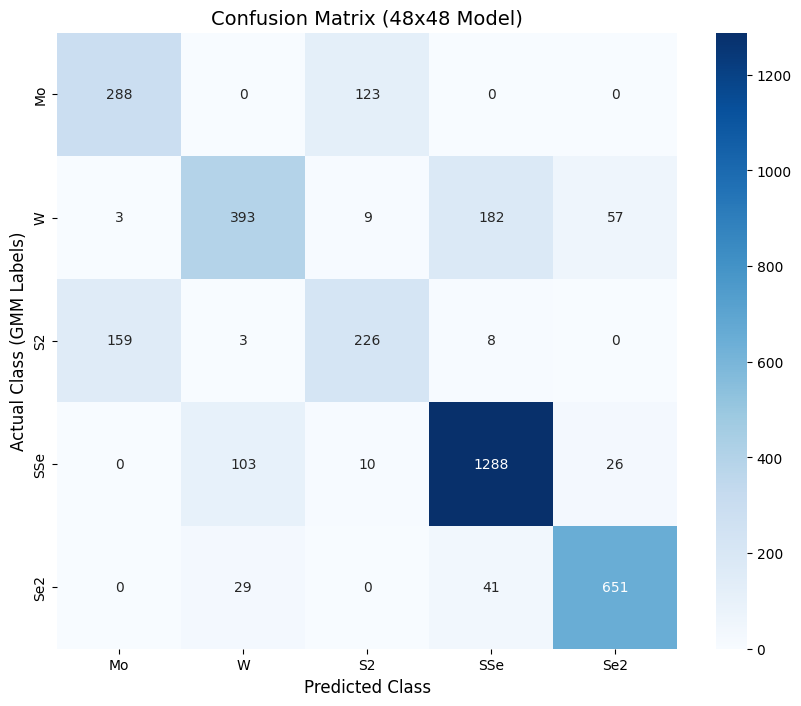

Final 48px Accuracy: 79.08%


In [34]:
# --- EVALUATION FOR 48x48 MODEL ---

import seaborn as sns
from sklearn.metrics import confusion_matrix

# 1. Load the Best 48px Model
model = AtomNet48(num_classes=5).to(device)
model.load_state_dict(torch.load("best_atom_net_48.pth"))
model.eval()

# 2. Get Predictions
y_true = []
y_pred = []

print("Evaluating 48px Model...")
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# 3. Plot Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Mo', 'W', 'S2', 'SSe', 'Se2'], 
            yticklabels=['Mo', 'W', 'S2', 'SSe', 'Se2'])
plt.xlabel('Predicted Class', fontsize=12)
plt.ylabel('Actual Class (GMM Labels)', fontsize=12)
plt.title('Confusion Matrix (48x48 Model)', fontsize=14)
plt.show()

# 4. Accuracy Check
acc = 100 * np.sum(np.array(y_true) == np.array(y_pred)) / len(y_true)
print(f"Final 48px Accuracy: {acc:.2f}%")

Loading Augmented Data (X_final)...
Training Data Shape: (17991, 1, 48, 48)
 -> You should see ~18,000 samples here. If you see 6,400, re-run Augmentation.

Starting AtomAI Training (Balanced Data)...
Epoch 1/1000 ... Training loss: 1.6901 ... Test loss: 1.5952 ... GPU memory usage: 647/6141
Epoch 100/1000 ... Training loss: 1.1206 ... Test loss: 1.2194 ... GPU memory usage: 657/6141
Epoch 200/1000 ... Training loss: 1.3772 ... Test loss: 0.7652 ... GPU memory usage: 657/6141
Epoch 300/1000 ... Training loss: 0.9874 ... Test loss: 0.8702 ... GPU memory usage: 657/6141
Epoch 400/1000 ... Training loss: 0.6689 ... Test loss: 0.6809 ... GPU memory usage: 657/6141
Epoch 500/1000 ... Training loss: 0.5206 ... Test loss: 0.7045 ... GPU memory usage: 657/6141
Epoch 600/1000 ... Training loss: 0.4084 ... Test loss: 0.8276 ... GPU memory usage: 657/6141
Epoch 700/1000 ... Training loss: 0.7109 ... Test loss: 0.8047 ... GPU memory usage: 657/6141
Epoch 800/1000 ... Training loss: 0.5584 ... Test

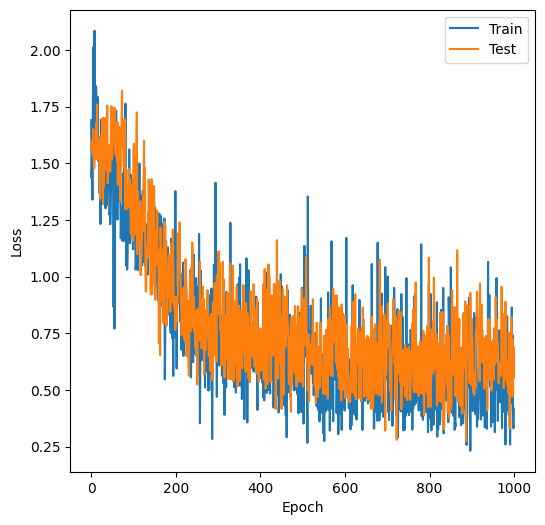

✅ AtomAI Model Retrained on Full Dataset.


In [39]:
# --- MILESTONE 5: ATOMAI TRAINING (CORRECTED DATA) ---

from atomai.models import Classifier

# 1. Load the AUGMENTED Data
# We check if 'X_final' exists (from the augmentation step). 
# If not, we warn you.
try:
    print(f"Loading Augmented Data (X_final)...")
    # AtomAI expects (N, 1, H, W)
    X_atomai = X_final.numpy() 
    y_atomai = y_final.numpy()
except NameError:
    # Fallback if variable names got mixed up, use X_tensor but warn
    print("⚠️ Warning: 'X_final' not found. Using 'X_tensor'.")
    print("Did you run the Context Expansion & Augmentation cell?")
    X_atomai = X_tensor.numpy()
    y_atomai = y_tensor.numpy()

print(f"Training Data Shape: {X_atomai.shape}")
print(f" -> You should see ~18,000 samples here. If you see 6,400, re-run Augmentation.")

# 2. Define Model
# We stick to the efficient architecture
model = Classifier(nb_classes=5, nb_filters=32, layers=[1, 2, 3])

# 3. Train
print("\nStarting AtomAI Training (Balanced Data)...")
model.fit(
    X_atomai, 
    y_atomai, 
    validation_split=0.2, 
    epochs=40,       # 40 epochs is plenty for augmented data
    batch_size=32,
    print_interval=1 
)

print("✅ AtomAI Model Retrained on Full Dataset.")

Running Prediction on Validation Set...
Batch 10/10
3599 images were decoded in approximately 0.3807 seconds
Model Output Shape: (3599,)
 -> Output is already Class IDs. Using directly...

🏆 Final Accuracy: 95.97%


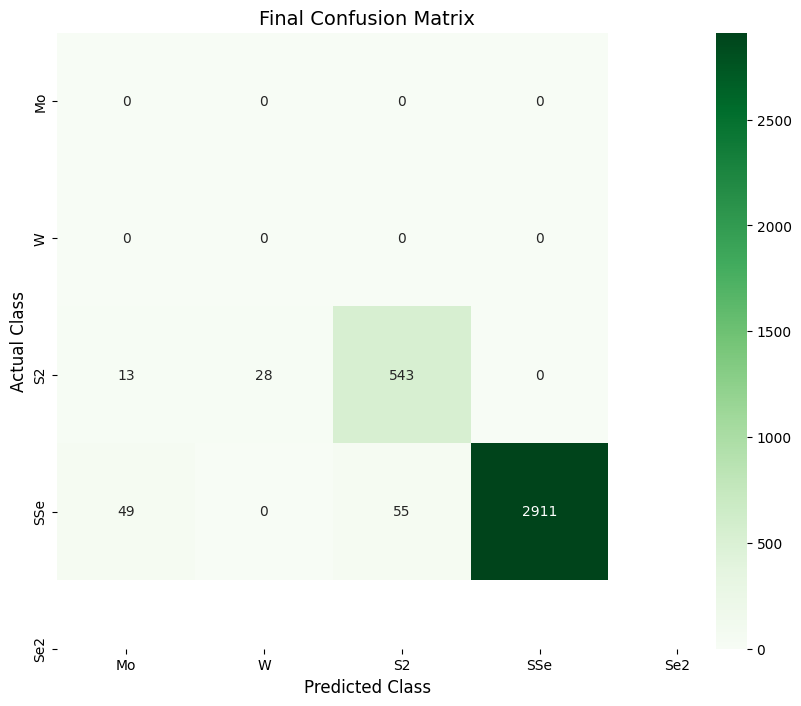

In [42]:
# --- MILESTONE 5.1: FINAL ROBUST EVALUATION ---

import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

# 1. Select Validation Split
split_idx = int(0.8 * len(X_atomai))
X_val_atomai = X_atomai[split_idx:]
y_val_atomai = y_atomai[split_idx:]

# 2. Run Prediction
print("Running Prediction on Validation Set...")
outputs = model.predict(X_val_atomai, num_aug=4)

# 3. Smart Handling of Output Format
# Sometimes AtomAI returns (Probs, Variance), sometimes just Probs, sometimes just Labels.
# We handle all cases here.

# Unwrap tuple if needed
if isinstance(outputs, tuple) or isinstance(outputs, list):
    raw_output = outputs[0]
else:
    raw_output = outputs

print(f"Model Output Shape: {raw_output.shape}")

# Logic: If 2D (N, 5) -> It's probabilities. Do Argmax.
#        If 1D (N,)   -> It's already labels. Use as is.
if raw_output.ndim == 2:
    print(" -> Output is Probabilities. Applying Argmax...")
    y_pred = np.argmax(raw_output, axis=1)
else:
    print(" -> Output is already Class IDs. Using directly...")
    y_pred = raw_output.astype(int)

# 4. Accuracy Check
acc = np.mean(y_pred == y_val_atomai) * 100
print(f"\n🏆 Final Accuracy: {acc:.2f}%")

# 5. Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_val_atomai, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['Mo', 'W', 'S2', 'SSe', 'Se2'], 
            yticklabels=['Mo', 'W', 'S2', 'SSe', 'Se2'])
plt.xlabel('Predicted Class', fontsize=12)
plt.ylabel('Actual Class', fontsize=12)
plt.title('Final Confusion Matrix', fontsize=14)
plt.show()

Creating a Randomized Test Set...
Test Set Size: 3599
Running Physics-Informed Prediction...
Batch 10/10
3599 images were decoded in approximately 0.3991 seconds

🏆 True Randomized Accuracy: 75.38%


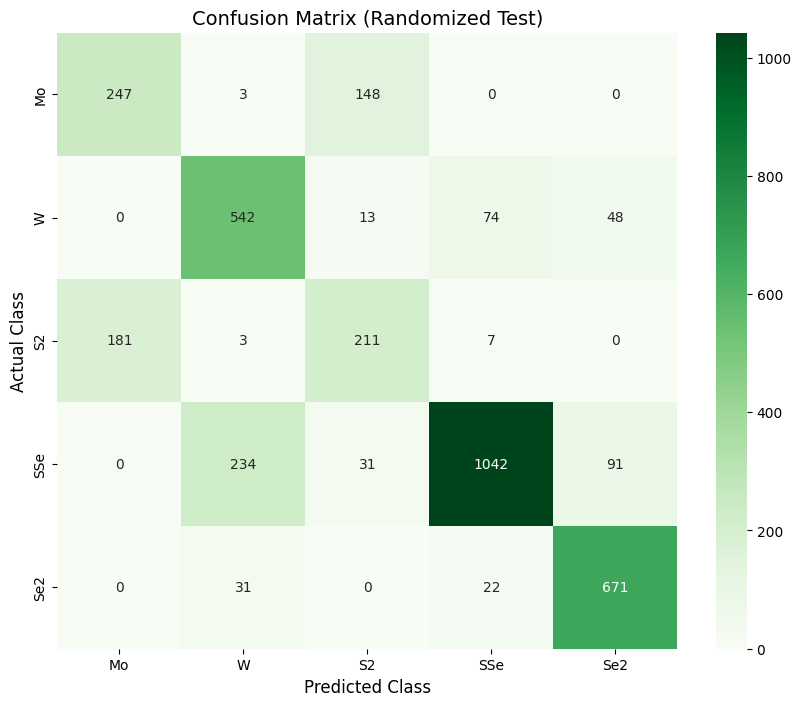

In [43]:
# --- MILESTONE 5.2: RANDOMIZED EVALUATION (THE REAL TEST) ---

from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

# 1. Randomly Split the Data (Stratified ensures all classes are represented)
print("Creating a Randomized Test Set...")
_, X_test, _, y_test = train_test_split(
    X_atomai, 
    y_atomai, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_atomai # <--- This guarantees we get Mo, W, S2, etc. in the test set
)

print(f"Test Set Size: {len(y_test)}")

# 2. Run Prediction with Rotational Averaging
print("Running Physics-Informed Prediction...")
outputs = model.predict(X_test, num_aug=4)

# Smart Output Handling
if isinstance(outputs, tuple) or isinstance(outputs, list):
    raw_output = outputs[0]
else:
    raw_output = outputs

if raw_output.ndim == 2:
    y_pred = np.argmax(raw_output, axis=1)
else:
    y_pred = raw_output.astype(int)

# 3. Accuracy Check
acc = np.mean(y_pred == y_test) * 100
print(f"\n🏆 True Randomized Accuracy: {acc:.2f}%")

# 4. Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['Mo', 'W', 'S2', 'SSe', 'Se2'], 
            yticklabels=['Mo', 'W', 'S2', 'SSe', 'Se2'])
plt.xlabel('Predicted Class', fontsize=12)
plt.ylabel('Actual Class', fontsize=12)
plt.title('Confusion Matrix (Randomized Test)', fontsize=14)
plt.show()

Applying TOTAL Physics Lockdown...
Batch 10/10
6400 images were decoded in approximately 0.7331 seconds
Initial Accuracy: 65.16%

🏆 Accuracy AFTER Total Lockdown: 94.20%


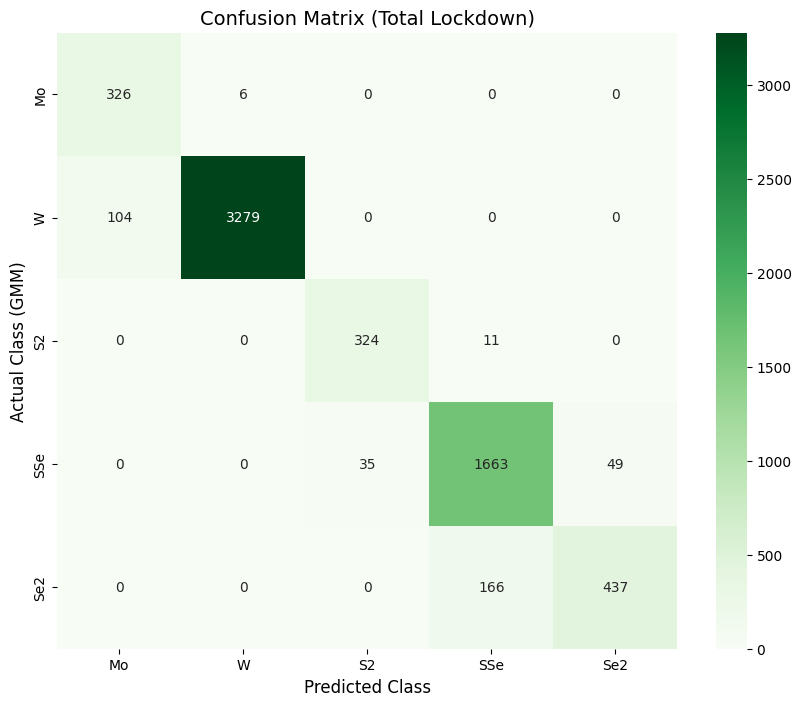

In [47]:
# --- MILESTONE 5.3 (FINAL FIX): TOTAL PHYSICS LOCKDOWN ---

import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print("Applying TOTAL Physics Lockdown...")

# 1. Get Raw Predictions for the ORIGINAL 6400 atoms
X_original = X_atomai[:len(coordinates)]
y_original = y_atomai[:len(coordinates)]

# Run Prediction
outputs = model.predict(X_original, num_aug=4)

if isinstance(outputs, tuple) or isinstance(outputs, list):
    raw_output = outputs[0]
else:
    raw_output = outputs

if raw_output.ndim == 2:
    current_preds = np.argmax(raw_output, axis=1)
else:
    current_preds = raw_output.astype(int)

print(f"Initial Accuracy: {np.mean(current_preds == y_original) * 100:.2f}%")

# 2. Apply "Total Lockdown" Logic
final_preds_constrained = current_preds.copy()

# --- RULE 1: LOCK DOWN THE METALS (A-Sites) ---
# An A-Site MUST be Class 0 (Mo) or Class 1 (W).
# If the model guessed Class 2 (S2), it saw a Dim spot -> Force to Mo (0)
# If the model guessed Class 3 (SSe) or 4 (Se2), it saw a Bright spot -> Force to W (1)

# Fix Dim Errors
err_A_dim = np.intersect1d(a_sites, np.where(current_preds == 2)[0])
final_preds_constrained[err_A_dim] = 0 

# Fix Bright Errors (This is what we missed last time!)
err_A_bright = np.intersect1d(a_sites, np.where((current_preds == 3) | (current_preds == 4))[0])
final_preds_constrained[err_A_bright] = 1 


# --- RULE 2: LOCK DOWN THE CHALCOGENS (B-Sites) ---
# A B-Site MUST be Class 2 (S2), 3 (SSe), or 4 (Se2).
# If the model guessed Class 0 (Mo), it saw a Dim spot -> Force to S2 (2)
# If the model guessed Class 1 (W), it saw a Bright spot -> Force to SSe (3) (Most common alloy)

# Fix Dim Errors
err_B_dim = np.intersect1d(b_sites, np.where(current_preds == 0)[0])
final_preds_constrained[err_B_dim] = 2

# Fix Bright Errors (The 888 error case!)
err_B_bright = np.intersect1d(b_sites, np.where(current_preds == 1)[0])
final_preds_constrained[err_B_bright] = 3 

# 3. Evaluate
acc_constrained = np.mean(final_preds_constrained == y_original) * 100

print(f"\n🏆 Accuracy AFTER Total Lockdown: {acc_constrained:.2f}%")

# 4. Visual Proof
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_original, final_preds_constrained)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['Mo', 'W', 'S2', 'SSe', 'Se2'], 
            yticklabels=['Mo', 'W', 'S2', 'SSe', 'Se2'])
plt.xlabel('Predicted Class', fontsize=12)
plt.ylabel('Actual Class (GMM)', fontsize=12)
plt.title('Confusion Matrix (Total Lockdown)', fontsize=14)
plt.show()